# Project Overview

Earlier in the year, our client, a grocery retailer, ran a campaign to promote their new “Delivery Club” - an initiative that costs a customer =100 per year for membership, but offers free grocery deliveries rather than the normal cost of $10 per delivery.

They want to understand if customers who did join the club have increased their spend in the three months following. The hypothesis is that, if customers are not paying for deliveries, they will be tempted to shop more frequently, and hopefully purchase more each time.

The aim of this work is to understand and quantify the uplift in sales for customers that joined the club, over and above what they would have spent had the club not come into existence!




In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [29]:
print(pd.__version__)

2.0.3


In [30]:
from causalimpact import CausalImpact

In [31]:
transactions = pd.read_excel(r'/Users/praju/Desktop/DSI/Untitled Folder/CIA/grocery_database.xlsx',sheet_name='transactions')
campaign_data = pd.read_excel(r'/Users/praju/Desktop/DSI/Untitled Folder/CIA/grocery_database.xlsx',sheet_name='campaign_data')

In [32]:
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


In [33]:
campaign_data.head()

,customer_id,campaign_name,campaign_date,mailer_type,signup_flag
0,74,delivery_club,2020-07-01,Mailer1,1
1,524,delivery_club,2020-07-01,Mailer1,1
2,607,delivery_club,2020-07-01,Mailer2,1
3,343,delivery_club,2020-07-01,Mailer1,0
4,322,delivery_club,2020-07-01,Mailer2,1


In [34]:
customer_daily_sales = transactions.groupby(["customer_id","transaction_date"])["sales_cost"].sum().reset_index()

In [35]:
customer_daily_sales.head()

,customer_id,transaction_date,sales_cost
0,1,2020-04-10,26.87
1,1,2020-06-02,65.49
2,1,2020-06-10,71.71
3,1,2020-06-19,61.91
4,1,2020-07-02,471.71


In [36]:
customer_daily_sales = pd.merge(customer_daily_sales,campaign_data,how='inner',on='customer_id')

In [37]:
customer_daily_sales.head()

,customer_id,transaction_date,sales_cost,campaign_name,campaign_date,mailer_type,signup_flag
0,1,2020-04-10,26.87,delivery_club,2020-07-01,Mailer2,1
1,1,2020-06-02,65.49,delivery_club,2020-07-01,Mailer2,1
2,1,2020-06-10,71.71,delivery_club,2020-07-01,Mailer2,1
3,1,2020-06-19,61.91,delivery_club,2020-07-01,Mailer2,1
4,1,2020-07-02,471.71,delivery_club,2020-07-01,Mailer2,1


In [38]:
customer_daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16979 entries, 0 to 16978
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       16979 non-null  int64         
 1   transaction_date  16979 non-null  datetime64[ns]
 2   sales_cost        16979 non-null  float64       
 3   campaign_name     16979 non-null  object        
 4   campaign_date     16979 non-null  datetime64[ns]
 5   mailer_type       16979 non-null  object        
 6   signup_flag       16979 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 928.7+ KB


In [39]:
customer_daily_sales.groupby(['transaction_date','signup_flag'])['sales_cost'].mean()

transaction_date  signup_flag
2020-04-01        0               74.463333
                  1              194.488065
2020-04-02        0               75.558254
                  1              185.161667
2020-04-03        0               74.387353
                                    ...    
2020-09-28        1              157.158750
2020-09-29        0               80.383088
                  1              157.480385
2020-09-30        0               54.014359
                  1              184.352963
Name: sales_cost, Length: 366, dtype: float64

In [40]:
causal_impact_df = customer_daily_sales.pivot_table(index="transaction_date",
                                                   columns="signup_flag",
                                                   values="sales_cost",
                                                   aggfunc="mean")

In [41]:
causal_impact_df

signup_flag,0,1
transaction_date,,
2020-04-01,74.463333,194.488065
2020-04-02,75.558254,185.161667
2020-04-03,74.387353,118.121333
2020-04-04,63.003797,198.525357
2020-04-05,72.440441,145.456000
...,...,...
2020-09-26,67.471786,189.737419
2020-09-27,91.421525,237.735357
2020-09-28,65.681692,157.158750


In [42]:
causal_impact_df.index
# currently we have freq = "None", when we run causalimpact it throws warning, as it does not know
# what the frequency is
# it still works, but it gives us warning messages

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10',
               ...
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='transaction_date', length=183, freq=None)

In [43]:
# to change this to daily freq, we can specify that
causal_impact_df.index.freq = "D"

In [44]:
causal_impact_df.index

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10',
               ...
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='transaction_date', length=183, freq='D')

In [45]:
# causal analysis want to have the impacted group in the first column
# in our case this is the group that "Signup"
# at the moment they are in second column

causal_impact_df = causal_impact_df[[1,0]]

In [46]:
causal_impact_df

signup_flag,1,0
transaction_date,,
2020-04-01,194.488065,74.463333
2020-04-02,185.161667,75.558254
2020-04-03,118.121333,74.387353
2020-04-04,198.525357,63.003797
2020-04-05,145.456000,72.440441
...,...,...
2020-09-26,189.737419,67.471786
2020-09-27,237.735357,91.421525
2020-09-28,157.158750,65.681692


In [47]:
# renaming 1 and 0

causal_impact_df.columns=["Member","Non-Member"]

In [49]:
causal_impact_df.head()

,Member,Non-Member
transaction_date,,
2020-04-01,194.488065,74.463333
2020-04-02,185.161667,75.558254
2020-04-03,118.121333,74.387353
2020-04-04,198.525357,63.003797
2020-04-05,145.456000,72.440441


In the DataFrame we have the transaction data, and then a column showing the average daily sales for those who signed up (member) and those who did not (non_member). This is the required format for applying the algorithm.

In [48]:
causal_impact_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2020-04-01 to 2020-09-30
Freq: D
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Member      183 non-null    float64
 1   Non-Member  183 non-null    float64
dtypes: float64(2)
memory usage: 4.3 KB


In the code below, we specify the start and end dates of the “pre-period” and the start and end dates of the “post-period”. We then apply the algorithm by passing in the DataFrame and the specified pre and post period time windows.

The algorithm will model the relationship between members & non-members in the pre-period - and it will use this to create the counterfactual, in other words what it believes would happen to the average daily spend for members in the post-period if no event was to have taken place!

The difference between this counterfactual and the actual data in the post-period will be our “causal impact”

In [21]:
# apply causal impact
# we need to specify start date and end date of pre-period and post period
# in our case we have 6 months data and membership went live on "1st of July"

# so our pre-period will be from 1st of april to 30th of june
# so our post-period will be from "1st of july" till "30th of sept"

# causal mpact want these in form of list

pre_period = ["2020-04-01","2020-06-30"]
post_period = ["2020-07-01","2020-09-30"]

In [22]:
ci = CausalImpact(causal_impact_df, pre_period, post_period)

/Users/praju/anaconda3_latest/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(


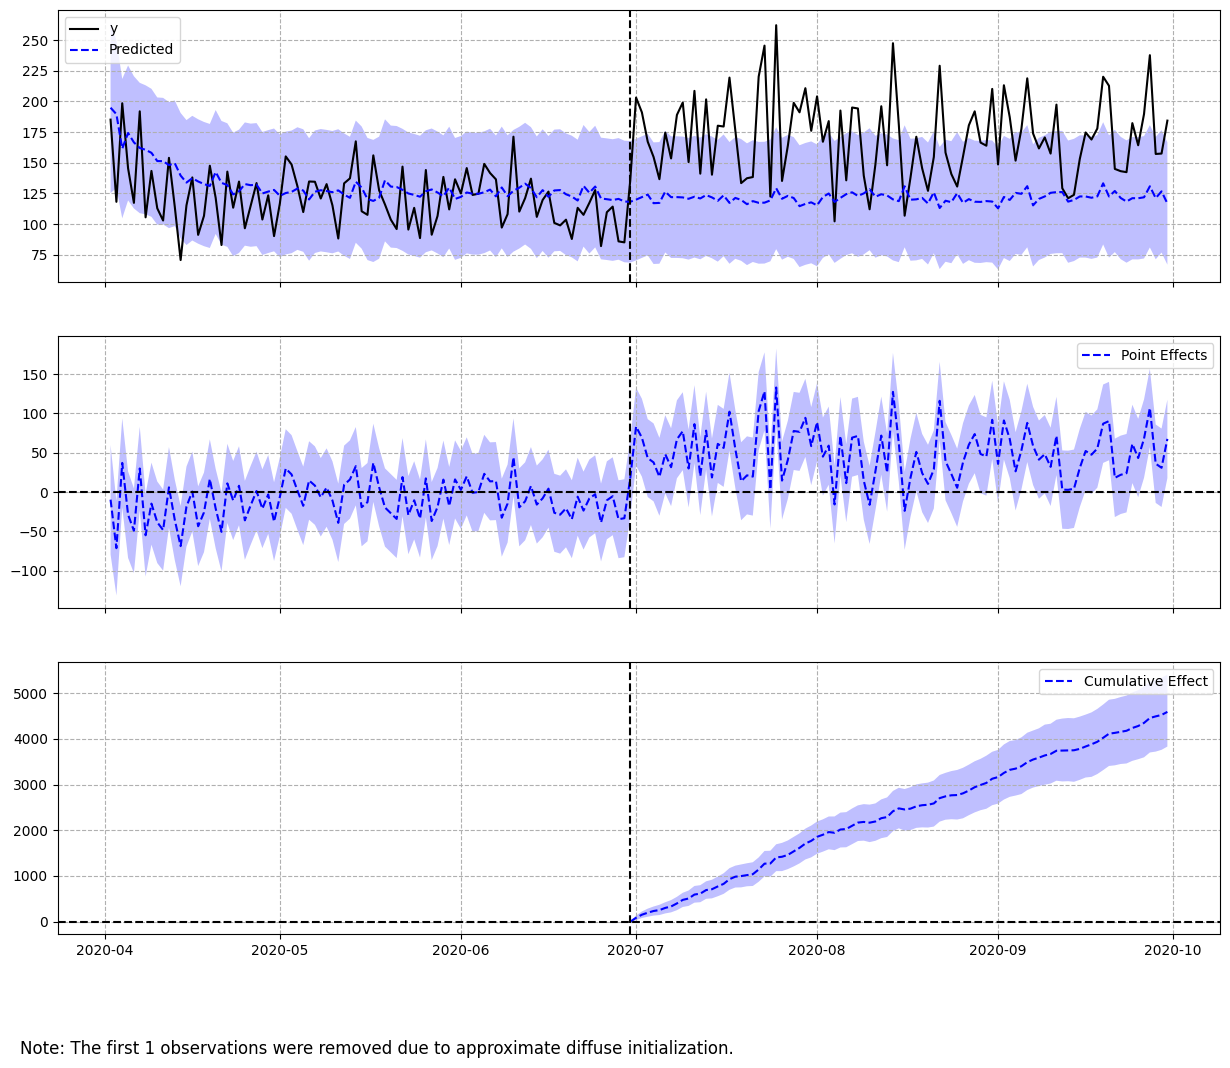

In [23]:
ci.plot()

To explain what we have in the above image…

The vertical dotted line down the middle of each plot is the date that the Delivery Club membership started. Everything to the left of this dotted line is the pre-period, and everything to the right of the dotted line is the post-period.


Chart 1: **Actual vs. Counterfactual**

The top chart shows the actual data for the impacted group as a black line, in other words the actual average daily sales for customers who did go on to sign up to the Delivery Club. You can also see the counterfactual, which is shown with the blue dotted line. The purple area around the blue dotted line represent the confidence intervals around the counterfactual - in other words, the range in which the algorithm believes the prediction should fall in. A wider confidence interval suggests that the model is less sure about it’s counterfactual prediction - and this is all taken into account when we look to quantify the actual uplift.

Just eyeing this first chart, it does indeed look like there is some increase in daily average spend for customers who joined the club, over-and-above what the model suggests they would have done, if the club was never in existence. We will look at the actual numbers for this very soon.


Chart 2: **Pointwise Effects**

This second chart shows us, for each day (or data point in general) in our time-series, the raw differences between the actual values and the values for the counterfactual. It is plotting the differences from Chart 1. As an example, if on Day 1 the actual and the counterfactual were the same, this chart would show a value of 0. If the actual is higher than the counterfactual then we would see a positive value on this chart, and vice versa. It is essentially showing how far above or below the counterfactual, the actual values are.

What is interesting here is that for the pre-period we see a difference surrounding zero, but in the post period we see mostly positive values mirroring what we saw in Chart 1 where the actual average spend was greater than the counterfactual.


Chart 3: **Cumulative Effects**

The bottom chart shows the cumulative uplift over time. In other words this chart is effectively adding up the Pointwise contributions from the second chart over time. This is very useful as it helps the viewer get a feel for what the total uplift or difference is at any point in time.

As we would expect based on the other two charts, there does appear to be a cumulative uplift over time.



In [24]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    171.33             15762.67
Prediction (s.d.)         121.42 (4.37)      11170.19 (402.09)
95% CI                    [112.54, 129.67]   [10353.9, 11930.08]

Absolute effect (s.d.)    49.92 (4.37)       4592.48 (402.09)
95% CI                    [41.66, 58.79]     [3832.59, 5408.78]

Relative effect (s.d.)    41.11% (3.6%)      41.11% (3.6%)
95% CI                    [34.31%, 48.42%]   [34.31%, 48.42%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


At the top of the results summary (above) we see that in the post-period the average actual daily sales per customer over the post-period was 171 dollar, higher than that of the counterfactual, which was 121 dollar. This counterfactual prediction had 95% confidence intervals of 113 dollar and 130 dollar.

Below that we can see the absolute effect which is the difference between actual and counterfactual (so the difference between 171 dollar and 121 dollar) - and this figure is essentially showing us the average daily uplift in sales over the post-period. We also get the confidence intervals surrounding that effect, and since these do not pass through zero, we can confidently say that there was an uplift driven by the Delivery Club.

Below that, we get these same numbers - as percentages.

In the columns on the right of the summary, we see the cumulative values for these across the entire post-period, rather than the average per day.

What is amazing about the pycausalimpact library is that, with an extra parameter, we can actually get all of this information provided as a written output.

If we put:

In [25]:
# results summary - report
print(ci.summary(output = "report"))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 171.33. By contrast, in the absence of an
intervention, we would have expected an average response of 121.42.
The 95% interval of this counterfactual prediction is [112.54, 129.67].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 49.92 with a 95% interval of
[41.66, 58.79]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 15762.67.
By contrast, had the intervention not taken place, we would have expected
a sum of 11170.19. The 95% interval of this prediction is [10353.9, 11930.08].


The above results are given in terms of absolute numbers. In relative
terms, the resp

So, this is the same information as we saw above, but put into a written report which can go straight to the client.

The high level story of this that, yes, we did see an uplift in sales for those customers that joined the Delivery Club, over and above what we believe they would have spent, had the club not been in existence. This uplift was deemed to be significantly significant (@ 95%)